## Model

- $x$ is an $8x8$ image.
$$y = \alpha(x) + \beta(x) z + u$$
$$u \sim N(0,1)$$


## Data

In [3]:
import numpy as np
import torch
from torch import nn
from sklearn.metrics import r2_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(0)
torch.manual_seed(0)

n = 10000
seq_length = 5
z = np.random.randint(0, 2, size=(n, 1)).astype(np.float32)
u = np.random.normal(0, 0.1, size=(n, 1)).astype(np.float32)
x = np.random.rand(n, seq_length).astype(np.float32)  # Random sequences

class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=32, num_layers=1, batch_first=True)
        self.fc_layers = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = x.unsqueeze(-1)  # Add a channel dimension
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Use the last LSTM output
        return self.fc_layers(x) * 10

model = LSTM().to(device)

x = torch.tensor(x, dtype=torch.float32).to(device)
z = torch.tensor(z, dtype=torch.float32).to(device)
u = torch.tensor(u, dtype=torch.float32).to(device)

with torch.no_grad():
    model.eval()
    ab = model(x)
    a = ab[:, 0].unsqueeze(1)
    b = ab[:, 1].unsqueeze(1)
    y = a + b * z + u

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_fn = nn.MSELoss(reduction='sum')

num_epochs = 30000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    alpha_beta = model(x)
    alpha = alpha_beta[:, 0].unsqueeze(1)
    beta = alpha_beta[:, 1].unsqueeze(1)
    y_pred = alpha + beta * z
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()
    if epoch % (num_epochs/10) == 0:
        r2 = r2_score(y_pred.cpu().detach().numpy(), y.cpu().detach().numpy())
        print(f"Epoch {epoch + 1}, Loss: {loss.item()}, Test R2 Score: {r2}")


Epoch 1, Loss: 997.6260986328125, Test R2 Score: 0.9184315329705693


KeyboardInterrupt: 

ESTIMATION

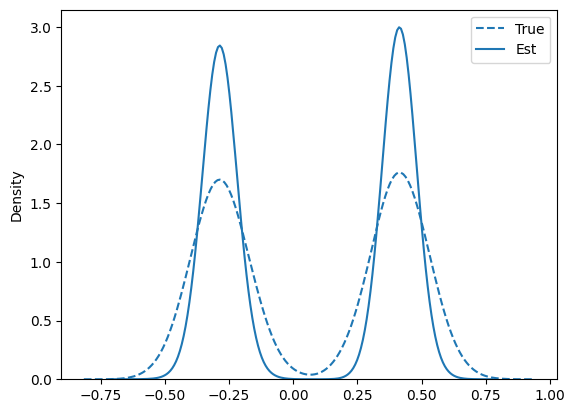

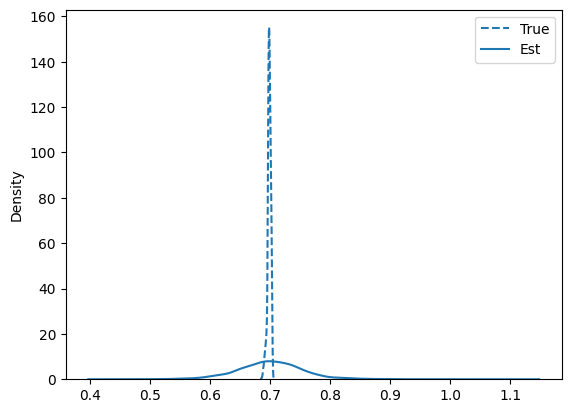

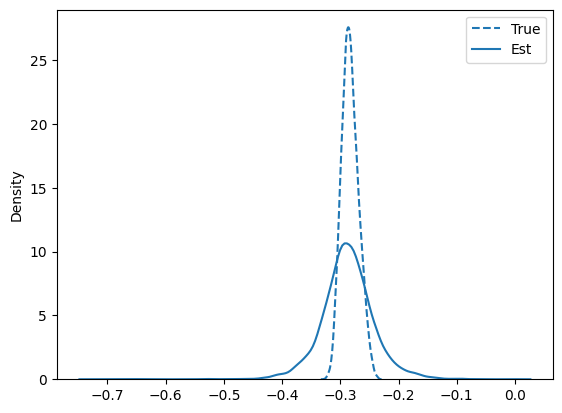

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot for y
sns.kdeplot(y.cpu().detach().numpy(), label='True', linestyle='--')
sns.kdeplot(y_pred.cpu().detach().numpy(), label='Est', color='red')
plt.legend()
plt.show()

# Assuming b represents true beta values
sns.kdeplot(b.cpu().detach().numpy(), label='True', linestyle='--')
sns.kdeplot(beta.cpu().detach().numpy(), label='Est', color='red')
plt.legend()
plt.show()

# Assuming a represents true alpha values
sns.kdeplot(a.cpu().detach().numpy(), label='True', linestyle='--')
sns.kdeplot(alpha.cpu().detach().numpy(), label='Est', color='red')
plt.legend()
plt.show()


### INFERENCE

In [ ]:
Z = z.clone()
Y = y.clone()
Y_hat = y_pred.clone()
mu0 = alpha.clone()
mu1 = beta.clone()
e = torch.mean(Z)
IF = (mu1 + Z * (Y-mu1)/e) - (mu0+(1-Z)*(Y-mu0)/(1-e))
DR_est = torch.mean(IF)
DR_se = torch.sqrt(torch.var(IF)/n)
print(DR_est.item(), DR_se.item())

0.3257720172405243 0.00446738488972187


Hessian Based Inference

- Let a, b be vectors. We compute empirical loss L(y, t, a, b) and optimized that to get estiamtes a, b. Both of size nx1.

- Now let the gradients of loss to a and b be called abg. this is a nx2 gradient matrix.

- Now we compute 2x2 avg hessian. This involves finding the second derivative of each element in L wrt each element in a and b. Then the (0,0) element of hessian is sum of second derivatives of L w.r.t each element in a. Then the (1,1) element of hessian is sum of second derivatives of L w.r.t each element in b. Then the (1,0) element of hessian is sum of derivatives of L w.r.t first element in a and first elemnt in b.  

In [ ]:
import torch
import torch.nn as nn

# Forward pass to get predictions

params = model(x)
alpha = params[:, 0]
beta = params[:, 1]
y_hat = alpha + beta * z

# Compute loss and gradients
loss_fn = nn.MSELoss(reduction='sum')
loss = 0.5 * loss_fn(y_hat, y)
param_grads = torch.autograd.grad(loss, params, create_graph=True)[0]

# Compute Hessian
K = param_grads.shape[1]
hess = torch.zeros(K, K, device=params.device)
for j in range(K):
    for i in range(K):
        sum_param_grads = param_grads[:, j].sum()
        grad_of_sumParamGrads = torch.autograd.grad(sum_param_grads, params, retain_graph=True)[0]
        hess[i, j] = grad_of_sumParamGrads[:, i].mean()

# Fisher Information and ATE estimation
fisher_info = -torch.linalg.inv(hess)
betas = params[:, 1]
betas_sum_grad = torch.autograd.grad(betas.sum(), params)[0]

# Influence function for ATE
IF = betas + torch.stack([torch.dot(betas_sum_grad[j], torch.mv(fisher_info, param_grads[j])) for j in range(n)])
ate_est = IF.mean().item()
ate_se = IF.std().item() / torch.sqrt(torch.tensor(n, device=params.device))
print(f"ATE Estimate: {ate_est}, ATE Standard Error: {ate_se}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10000, 1])) that is different to the input size (torch.Size([10000, 10000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ATE Estimate: 0.32296013832092285, ATE Standard Error: 2.6232374605861253e-10
